# 2024-03-05, Day 02

quality control, normalisation

In [1]:
import scanpy as sc
import pandas as pd
import numpy as np

/opt/homebrew/Caskroom/miniforge/base/envs/ascc24/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
adata = sc.datasets.pbmc3k()

/opt/homebrew/Caskroom/miniforge/base/envs/ascc24/lib/python3.9/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


In [3]:
adata

AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'

we keep exploring the QC metrics that ScanPy offers, and try to understand how to use them as proxies for cell quality.

In [4]:
sc.pp.calculate_qc_metrics(adata, inplace=True)

/opt/homebrew/Caskroom/miniforge/base/envs/ascc24/lib/python3.9/site-packages/scanpy/plotting/_anndata.py:839: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(


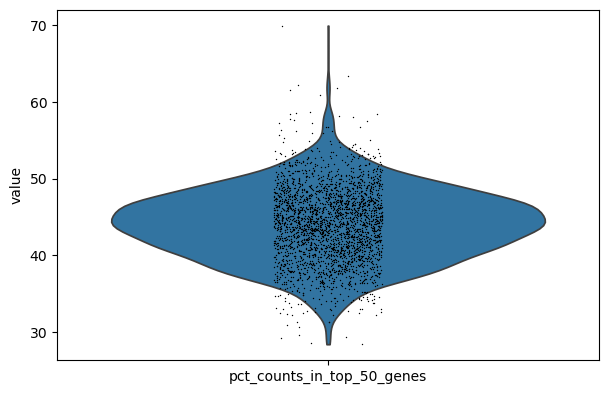

In [5]:
sc.pl.violin(adata, 'pct_counts_in_top_50_genes')

Is this surprising? What would we expect? What genes might those be?

We take a look at the top 50 most highly expressed genes and look them up to see what functions they have.

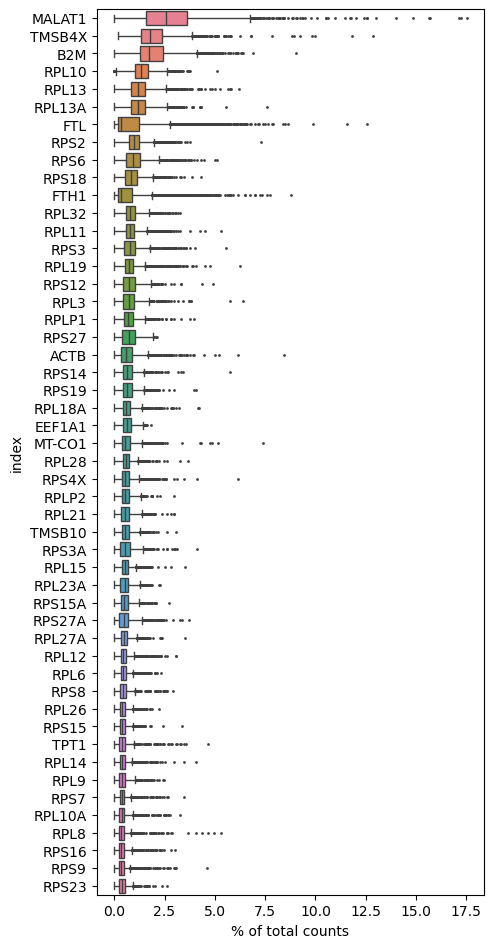

In [6]:
sc.pl.highest_expr_genes(adata, n_top=50)

We see that the list is dominated by metabolic, structural, and ribosomal genes. These are not particularly informative for discerning cell types from one another. Should we remove them from the dataset? Why/why not?

In [7]:
from matplotlib import pyplot as plt

In [8]:
adata.var

,gene_ids,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts
index,,,,,,,
MIR1302-10,ENSG00000243485,0,0.0,0.0,100.0,0.0,0.0
FAM138A,ENSG00000237613,0,0.0,0.0,100.0,0.0,0.0
OR4F5,ENSG00000186092,0,0.0,0.0,100.0,0.0,0.0
RP11-34P13.7,ENSG00000238009,0,0.0,0.0,100.0,0.0,0.0
RP11-34P13.8,ENSG00000239945,0,0.0,0.0,100.0,0.0,0.0
...,...,...,...,...,...,...,...
AC145205.1,ENSG00000215635,0,0.0,0.0,100.0,0.0,0.0
BAGE5,ENSG00000268590,0,0.0,0.0,100.0,0.0,0.0
CU459201.1,ENSG00000251180,0,0.0,0.0,100.0,0.0,0.0


We have a look at the distribution of average gene expression. It is extremely skewed, with the overwhelming majority of genes being almost not expressed. Can we think of reasons why? Can we think of factors that might explain this? Why is this so different from the total/average counts per cell?

<details>
    <summary>hint</summary>
    - Remember the overall sparsity of the matrix. How would that manifest differently when summing up over the cells/genes?
    - could we be "seeing" plotting artefacts?
</details>

(0.0, 2.0)

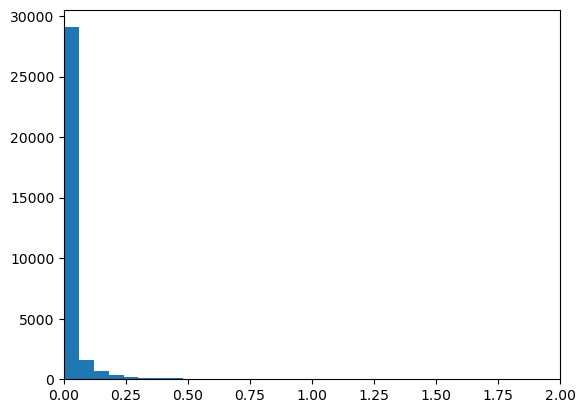

In [9]:
fig, ax = plt.subplots()
ax.hist(adata.var["mean_counts"], bins=1000);
ax.set_xlim(left=0, right=2)

Clearly, many genes are at the border of detectability. How many cells should we require a gene to be expressed in for us to take it into account?

This led us to a discussion about cell numbers. How many cells of a certain cell type would we need to see before they became a believable grouping? How is that influenced by how many cells are in our sample/experiment?

In [10]:
sc.pp.filter_genes(adata, min_cells=5)

just removing genes that are barely expressed is a massive difference! We are 20k dimensions down, which will surely make things easier.

In [11]:
adata

AnnData object with n_obs × n_vars = 2700 × 12572
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'gene_ids', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'

We said that looking at cell-cell similarity is how we can detect patterns - well, calculating distances between them is one way to quantify similarity.

Make sure to `use_rep="X"`, otherwise scanpy will run a PCA analysis of its own.

In [12]:
sc.pp.neighbors(adata, metric="euclidean", use_rep="X")

We will use UMAPs to visualise the data. [UMAP](https://arxiv.org/abs/1802.03426) is an algorithm that projects multidimensional data to a low-dimensional manifold, and very widely used for visualisation. Said very roughly, the method tries to depict the data in 2 (or 3) dimensions in such a way that the distances between points in 2D remain similar to their distances in multidimensional space. This is an optimisation problem that is impossibleto solve precisely, so UMAP tries to approximate it by taking different shortcuts. This means that UMAPs have random elements, and running a UMAP twice on the same data will not produce the same plot. It also means that distances in the plot should not be taken at face value; rather, we should look at UMAPs the same way we look at medieval maps: they get lots of things right, but we shouldn't rely on them to plan our journey from point A to point B.

In [13]:
sc.tl.umap(adata)

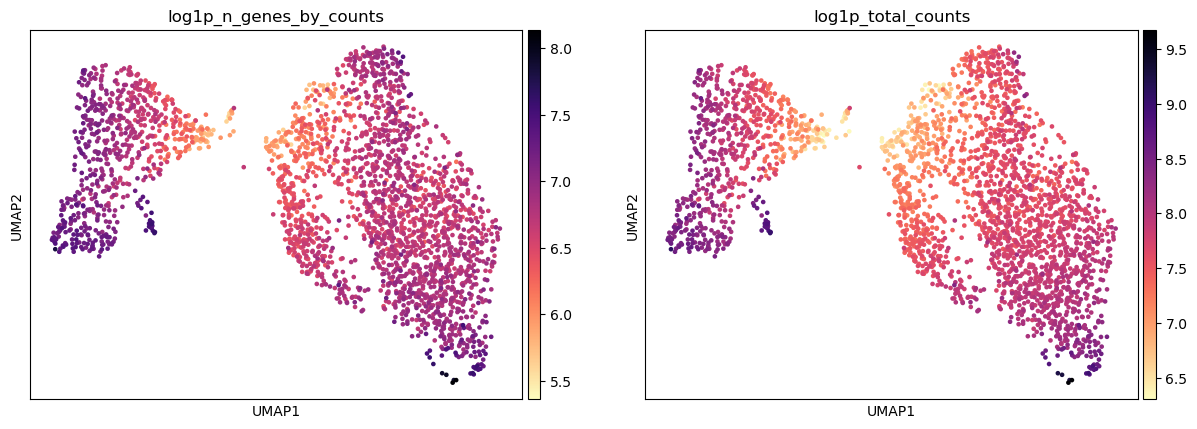

In [14]:
sc.pl.umap(adata, color=["log1p_n_genes_by_counts", "log1p_total_counts"], cmap="magma_r")

We notice that there is a clear gradient of total counts in each "continent". This means that cell size is an important driving factor in the pairwise distances! How could that happen?

<details>
    <summary>Hint</summary>
    A distance of, say, 10 doesn't mean the same thing in different expression regimes:
    - if cell A has 0 counts and cell B has 10, they probably don't belong to the same cell type
    - if cell A has 10 counts and cell B has 20, they may actually belong to the same cell type
    - if cell A has 100 counts and cell B has 110, they probably are the same cell type.
</details>

It is clear that at higher average expression the differences mean less; we have a higher tolerance for variance at high average expression. Let's explore how the data behaves: do we _actually_ see higher variance at higher averages?

In [15]:
adata.var["variance"] = np.var(np.array(adata.X.todense()), axis=0)

In [16]:
adata.var["log_var"] = np.log1p(adata.var["variance"])

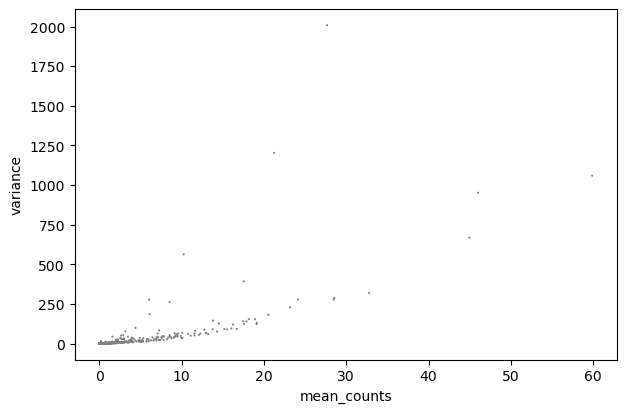

In [17]:
ax = sc.pl.scatter(adata, "mean_counts", "variance", show=False)
# ax.set_xlim(left=0, right=20)
# ax.set_ylim(bottom=0, top=150)

THere is a clear relationship between average and variance, and it even is non-linear. We noticed that in log space this relationship is linear, however, meaning that the variance is somehow proportional to the square of the mean:

$\sigma^2_g \sim \mu^2_g$

this means that at high average expression we should be expecting _very high_ variance; therefore, differences in expression in the high average regime (whicih would otherwise be valued very highly by distance metrics) should not be as important.

## various normalisations

Barbara had the idea to divide every count by the max expression value in the dataset and scale by 10:

In [18]:
adata.obsm["barbara"] = adata.X / adata.X.max() * 10
sc.pp.neighbors(adata, use_rep="barbara",  metric="euclidean", key_added="barb")
sc.tl.umap(adata, neighbors_key="barb")
adata.obsm["X_umap_barb"] = adata.obsm["X_umap"].copy()

We can perform proportional fitting (normalize each cell by its total counts) and multiply by 1 million (CPM normalisation)

In [19]:
cpm = sc.pp.normalize_total(adata, target_sum=1000000, inplace=False)
adata.obsm["CPM"] = cpm["X"].copy()
sc.pp.neighbors(adata, use_rep="CPM",  metric="euclidean", key_added="cpm")
sc.tl.umap(adata, neighbors_key="cpm")
adata.obsm["X_umap_cpm"] = adata.obsm["X_umap"].copy()

We can perform proportional fitting (normalize each cell by its total counts) and multiply by 10,000 (CP10k normalisation)

In [20]:
cp10k = sc.pp.normalize_total(adata, target_sum=10000, inplace=False)
adata.obsm["CP10K"] = cp10k["X"].copy()
sc.pp.neighbors(adata, use_rep="CP10K",  metric="euclidean", key_added="cp10k")
sc.tl.umap(adata, neighbors_key="cp10k")
adata.obsm["X_umap_cp10k"] = adata.obsm["X_umap"].copy()

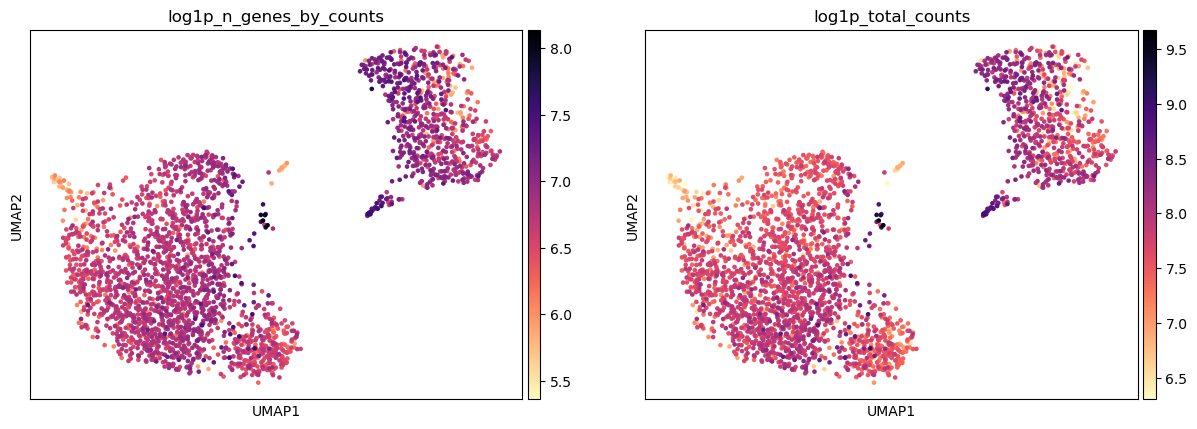

In [21]:
sc.pl.umap(adata, color=["log1p_n_genes_by_counts", "log1p_total_counts"], cmap="magma_r")

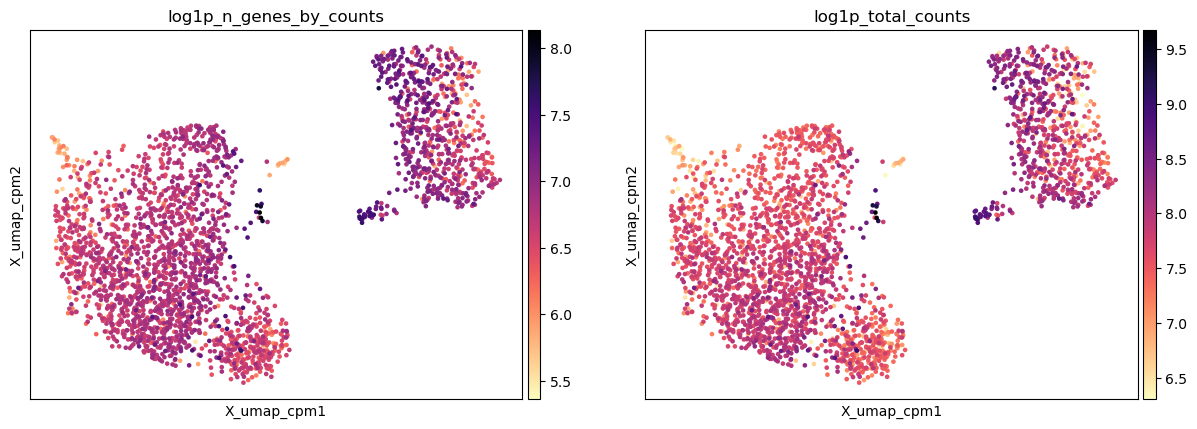

In [22]:
sc.pl.embedding(adata, basis="X_umap_cpm", color=["log1p_n_genes_by_counts", "log1p_total_counts"], cmap="magma_r")

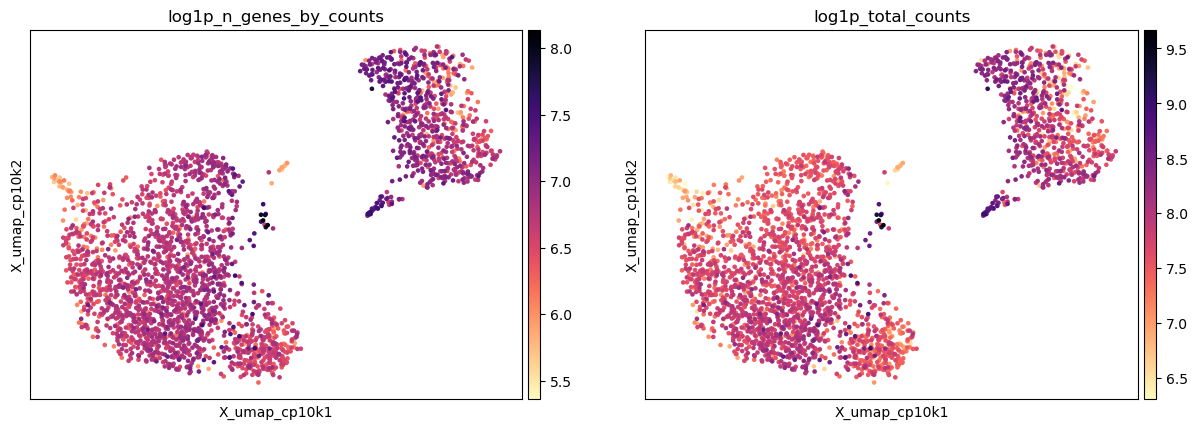

In [23]:
sc.pl.embedding(adata, basis="X_umap_cp10k", color=["log1p_n_genes_by_counts", "log1p_total_counts"], cmap="magma_r")

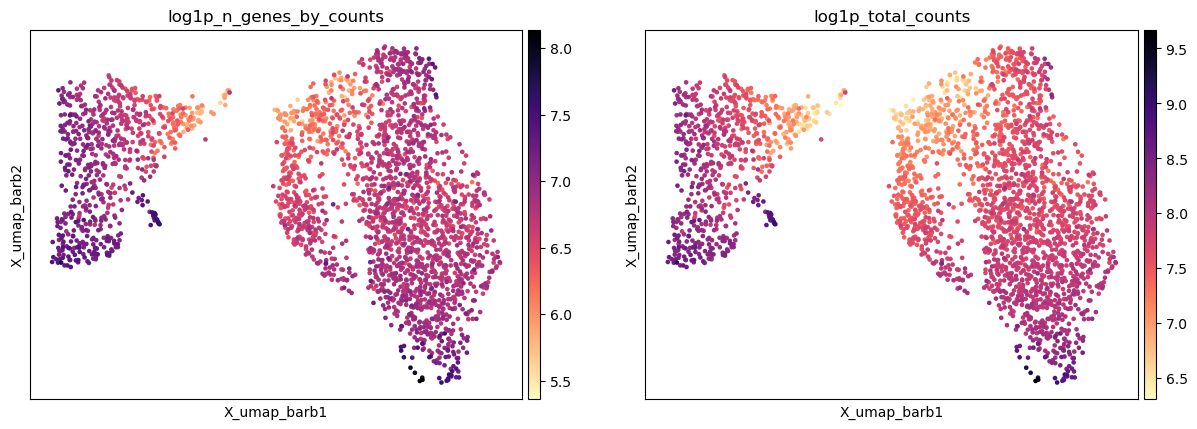

In [24]:
sc.pl.embedding(adata, basis="X_umap_barb", color=["log1p_n_genes_by_counts", "log1p_total_counts"], cmap="magma_r")

In comparison to using the raw counts it seems we have removed a lot of the influence of the total counts! Why did it not work for Barbara's idea?

Scanpy allows us to use multiple different distance metrics than Euclidean. How well do they work? Why would we want to _not_ use Euclidean distances?

In [25]:
adata.obsm["CP10k_dense"] = np.array(adata.obsm["CP10K"].todense())
sc.pp.neighbors(adata, use_rep="CP10k_dense",  metric="seuclidean", key_added="seq")
sc.tl.umap(adata, neighbors_key="seq")
adata.obsm["X_umap_seq"] = adata.obsm["X_umap"].copy()

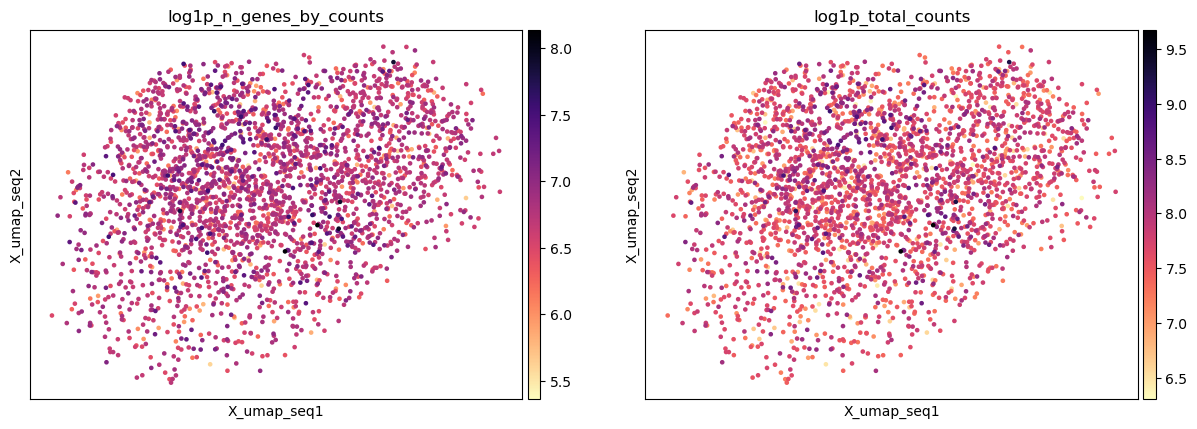

In [26]:
sc.pl.embedding(adata, basis="X_umap_seq", color=["log1p_n_genes_by_counts", "log1p_total_counts"], cmap="magma_r")

In [27]:
sc.pp.neighbors(adata, use_rep="CP10K",  metric="cityblock", key_added="cb")
sc.tl.umap(adata, neighbors_key="cb")
adata.obsm["X_umap_cb"] = adata.obsm["X_umap"].copy()

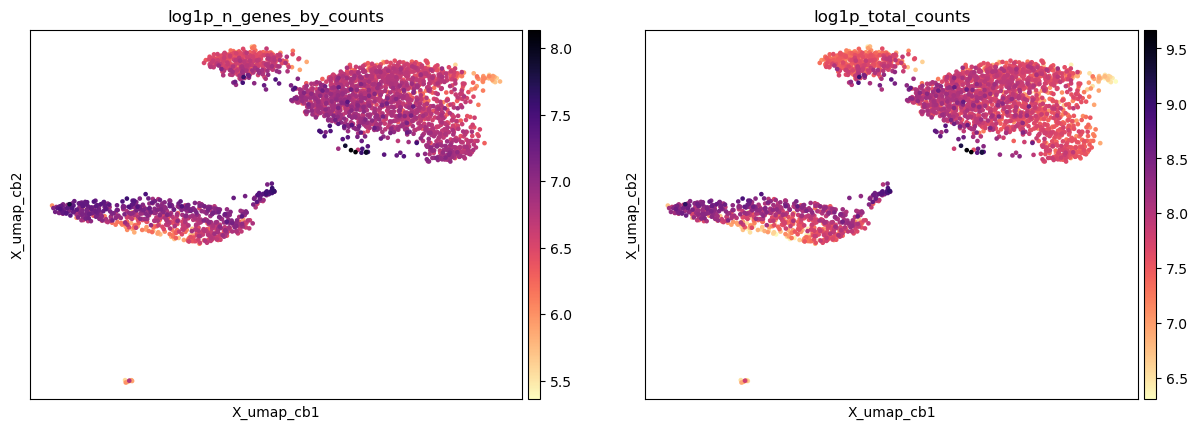

In [28]:
sc.pl.embedding(adata, basis="X_umap_cb", color=["log1p_n_genes_by_counts", "log1p_total_counts"], cmap="magma_r")